In [1]:
from rdkit import Chem as rdc
from collections import defaultdict
import json

RDKit WARNING: [03:46:33] Enabling RDKit 2019.09.3 jupyter extensions


# Script

## Single Monomer

In [2]:
class NoChiralCenters(Exception):
    pass
class NoCarboxyl(Exception):
    pass
class WTF(Exception):
    pass

In [3]:
def get_aa_chirality(smi):
    mol = rdc.MolFromSmiles(smi)
    chiral_centers = rdc.FindMolChiralCenters(mol)
    if not chiral_centers:
        raise NoChiralCenters
    
    RCN_pattern = 'RCN' * 2
    NCR_pattern = 'NCR' * 2
    def _get_chirality(match, q):
        for idx, rs in chiral_centers:
            #
            # Sadly, we cannot make use of rs here, see 
            # https://chemistry.stackexchange.com/questions/90826/difference-between-ld-and-sr-in-naming
            #
            if idx in match:
                ch_center = mol.GetAtomWithIdx(idx)
                neighbors = [a.GetIdx() for a in ch_center.GetNeighbors()]
                for match_cooh in mol.GetSubstructMatches(q):
                    neighbor_tags = []
                    for n in neighbors:
                        if n in match_cooh:
                            neighbor_tags.append('C')
                        elif mol.GetAtomWithIdx(n).GetSymbol() == 'N': 
                            neighbor_tags.append('N')
                        else:
                            neighbor_tags.append('R')
                    neighbor_tags = ''.join(neighbor_tags)

                    # since glutamic acid has several COOH matches
                    if neighbor_tags in RCN_pattern or neighbor_tags in NCR_pattern:
                        if ch_center.GetChiralTag() == rdc.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW:
                            return neighbor_tags in RCN_pattern
                        else:
                            return neighbor_tags in NCR_pattern
        return None
    
    # try beta
    query_beta = rdc.MolFromSmarts('NCC([C](=O)O)')
    match_beta = mol.GetSubstructMatch(query_beta)
    res_beta = None
    if match_beta:
        q = rdc.MolFromSmarts('CC([C](=O)O)')
        res_beta = _get_chirality(match_beta, q)
    
    # try alpha
    query_alpha = rdc.MolFromSmarts('NC([C](=O)O)')
    match_alpha = mol.GetSubstructMatch(query_alpha)
    res_alpha = None
    if match_alpha:
        q = rdc.MolFromSmarts('C([C](=O)O)')
        res_alpha = _get_chirality(match_alpha, q)
    
    if not match_alpha and not match_beta:
        raise NoCarboxyl
    
#     if res_alpha is not None:
#         if res_beta is not None:
#             raise WTF
#         else:
#             return res_alpha
    if res_alpha is not None:
        return res_alpha
    if res_beta is not None:
        return res_beta
    raise WTF

## Single Molecule

### Splitting

In [4]:
def get_monomer_bonds(mol, rban_record):
    atomic_bonds = rban_record["atomicGraph"]["atomicGraph"]['bonds']
    monomer_bonds_list = rban_record["monomericGraph"]["monomericGraph"]['bonds']
    
    monomer_bonds = []
    monomer_bond_types = []
    for bond_rec in monomer_bonds_list:
        for x in bond_rec['bond']['atomicIndexes']:
            b_ = mol.GetBondBetweenAtoms(*atomic_bonds[x]['atoms'])
            if b_:
                monomer_bonds.append(b_.GetIdx())
                monomer_bond_types.append(bond_rec['bond']["bondTypes"][0])
    
    return monomer_bonds, monomer_bond_types

In [5]:
def split_amino(rwmol, bonds, trans=False):
    for b_idx in sorted(bonds, reverse=True):
        # reverse because when a bond or atom is deleted, the bond or 
        # atom indices are remapped. If you remove bonds with a higher index first,
        # bonds with lower indices will not be remapped.
        b = rwmol.GetBondWithIdx(b_idx)
        st_ = b.GetBeginAtomIdx()
        end_ = b.GetEndAtomIdx()
        
        rwmol.RemoveBond(st_, end_)
        new_bond_type = rdc.BondType.DOUBLE if trans else rdc.BondType.SINGLE 
        if rwmol.GetAtomWithIdx(end_).GetSymbol() == 'C': 
            new_id = rwmol.AddAtom(rdc.Atom(8))
            rwmol.AddBond(end_, new_id, new_bond_type)
        if rwmol.GetAtomWithIdx(st_).GetSymbol() == 'C': 
            new_id = rwmol.AddAtom(rdc.Atom(8))
            rwmol.AddBond(st_, new_id, new_bond_type)
    return rwmol

In [6]:
def split_hetero(rwmol, bonds):
    
    carbon_ends = set()
    for b_idx in sorted(bonds, reverse=True):
        b = rwmol.GetBondWithIdx(b_idx)
        st_ = b.GetBeginAtomIdx()
        end_ = b.GetEndAtomIdx()
        rwmol.RemoveBond(st_, end_)
        for a in (st_, end_):
            if rwmol.GetAtomWithIdx(a).GetSymbol() == 'C': 
                carbon_ends.add(a)
    
    for a in carbon_ends:
        atom = rwmol.GetAtomWithIdx(a)
        atom.SetNumExplicitHs(0)
        atom.UpdatePropertyCache()
        valence = atom.GetExplicitValence()
        
        if valence == 1:
            new_id1 = rwmol.AddAtom(rdc.Atom(8))
            rwmol.AddBond(a, new_id1, rdc.BondType.SINGLE)

            new_id2 = rwmol.AddAtom(rdc.Atom(8))
            rwmol.AddBond(a, new_id2, rdc.BondType.DOUBLE)
        elif valence == 2:
            new_id2 = rwmol.AddAtom(rdc.Atom(8))
            rwmol.AddBond(a, new_id2, rdc.BondType.DOUBLE)
        elif valence == 3:
            new_id2 = rwmol.AddAtom(rdc.Atom(8))
            rwmol.AddBond(a, new_id2, rdc.BondType.SINGLE)
        
    return rwmol

In [7]:
def split_by_monomer_bonds(rban_record):
    HYDROX = ['AMINO', 'ESTER', 'THIOETHER', 'CARBON_CARBON', 'NITROGEN_CARBON2', 
              'NITROGEN_CARBON',
              'CARBON_CARBOXIL', 'CARBOXIL_CARBOXIL', 'GLYCOSIDIC']
    HYDROX_TRANS = ['AMINO_TRANS']
    HETERO = ['HETEROCYCLE', 'THIAZOLE_CYCLE', 'PYRIMIDINE_CYCLE']
    
    mol = rdc.MolFromSmiles(rban_record['isomericSmiles'])
    # kekulize so that we would not get this annoying Aromatic flag exception
    rdc.Kekulize(mol, clearAromaticFlags=True)
    
    # we will need editable mol instance
    rwmol = rdc.RWMol(mol)
    monomers = rban_record['monomericGraph']['monomericGraph']['monomers']
    
    bonds, types = get_monomer_bonds(rwmol, rban_record)
    amino_bonds = [b for b, t in zip(bonds, types) if t in HYDROX]
    rwmol = split_amino(rwmol, amino_bonds, trans=False)
    
    bonds, types = get_monomer_bonds(rwmol, rban_record)
    amino_trans_bonds = [b for b, t in zip(bonds, types) if t in HYDROX_TRANS]
    if amino_trans_bonds:
        rwmol = split_amino(rwmol, amino_trans_bonds, trans=True)
    
    # TODO: consider other(?) bond types
    
#     display(rdc.Draw.MolsToGridImage(rdc.GetMolFrags(rwmol, asMols=True)))
    
    bonds, types = get_monomer_bonds(rwmol, rban_record)
    hetero_bonds = [b for b, t in zip(bonds, types) if t in HETERO]
    if hetero_bonds:
        rwmol = split_hetero(rwmol, hetero_bonds)
 
#     display(rdc.Draw.MolsToGridImage(rdc.GetMolFrags(rwmol, asMols=True)))

    
    frag_ids = rdc.GetMolFrags(rwmol)
    frag_smi = [rdc.MolToSmiles(x) for x in rdc.GetMolFrags(rwmol, asMols=True)]

    monomer_smiles_dict = defaultdict(list)
    for k, monomer in enumerate(monomers):
        monomer_atoms = set(monomer['monomer']['atoms'])
        for i, frag_atoms in enumerate(map(set, frag_ids)):
            if len(monomer_atoms & frag_atoms) > 0:
                monomer_smiles_dict[k].append(frag_smi[i])
    return monomer_smiles_dict

### Get chirality

In [8]:
def get_monomers_chirality(rban_record, debug=False):
    monomers = rban_record['monomericGraph']['monomericGraph']['monomers']
    monomer_smiles_dict = split_by_monomer_bonds(rban_record)
    res = []
    for i in range(len(monomers)):
        try:
            res.append(get_aa_chirality(monomer_smiles_dict[i][0]))
        except NoChiralCenters:
            if debug: print(f'{i}: NoChiralCenters')
            res.append(False)
        except NoCarboxyl:
            if debug: print(f'{i}: NoCarboxyl')
            res.append(False)
        except WTF:
            print(f'{i}: WTF:', monomer_smiles_dict[i][0])
            res.append(False)
    return res

# Tests

## AA chirality

In [9]:
tests = [
    ('C[C@H]([C@@H](C(=O)O)N)O', 'L-(-)-Theanine'),
    ('C[C@@H]([C@H](C(=O)O)N)O', 'D-(+)-Theanine'),
    ('C1=CC=C(C=C1)[C@@H](CC(=O)[O-])[NH3+]', 'L-beta-Phenylalanine'),
    ('C1=CC=C(C=C1)[C@H](CC(=O)[O-])[NH3+]', 'D-beta-Phenylalanine'),
    ('C1=CC=C(C=C1)C[C@H](C(=O)O)N', 'D-Phenylalanine'),
    ('CC[C@@H](C(=O)O)N', 'L-2-Aminobutyric acid'),
    ('CC[C@H](C(=O)O)N', 'D-2-Aminobutyric acid'),
    ('C(CC(=O)O)[C@@H](C(=O)O)N', 'L-glutamic acid'),
    ('C(CC(=O)O)[C@H](C(=O)O)N', 'D-glutamic acid'),
]

for s, n in tests:
    print(n)
    for _ in range(5):
        rs = rdc.MolToSmiles(rdc.MolFromSmiles(s), doRandom=True)
        print(get_aa_chirality(rs), end=' ')
    print(end='\n\n')

L-(-)-Theanine
False False False False False 

D-(+)-Theanine
True True True True True 

L-beta-Phenylalanine
False False False False False 

D-beta-Phenylalanine
True True True True True 

D-Phenylalanine
True True True True True 

L-2-Aminobutyric acid
False False False False False 

D-2-Aminobutyric acid
True True True True True 

L-glutamic acid
False False False False False 

D-glutamic acid
True True True True True 



## DL for monomers in compound

In [10]:
mibig_results_json = json.loads(open('TestNerpa_MiBig_base/structure.info.output.json').read())

### TestMIBig bond types

In [11]:
bond_type_to_compounds = defaultdict(list)
for i, res in enumerate(mibig_results_json):
    for bond in res['monomericGraph']['monomericGraph']['bonds']:
        bond_type_to_compounds[bond['bond']['bondTypes'][0]].append(i)
for k in bond_type_to_compounds.keys():
    bond_type_to_compounds[k] = sorted(list(set(bond_type_to_compounds[k])))

In [12]:
for k,v in bond_type_to_compounds.items():
    print(k, v[:10])

AMINO [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
ESTER [2, 13, 14, 15, 18, 19, 20, 21, 24, 25]
CARBON_CARBOXIL [22, 29]
NITROGEN_CARBON2 [26]
THIAZOLE_CYCLE [30, 35, 44, 52]
CARBON_CARBON [33]
GLYCOSIDIC [42, 78]
PYRIMIDINE_CYCLE [47]
HETEROCYCLE [47, 54, 71, 78]
AMINO_TRANS [72]


### Helpers

In [13]:
from rdkit.Chem import AllChem
    
# http://rdkit.blogspot.com/2015/02/new-drawing-code.html
def moltosvg(rdkit_mol, size_x=450, size_y=150, highlightBonds=[]):
    highlightBondColors = {b : (1, .8, .8) for b in highlightBonds}
    
    AllChem.Compute2DCoords(rdkit_mol)
    try:
        rdkit_mol.GetAtomWithIdx(0).GetExplicitValence()
    except RuntimeError:
        rdkit_mol.UpdatePropertyCache(False)
    try:
        mc_mol = rdc.Draw.rdMolDraw2D.PrepareMolForDrawing(rdkit_mol, kekulize=True)
    except ValueError: # <- can happen on a kekulization failure
        mc_mol = rdc.Draw.rdMolDraw2D.PrepareMolForDrawing(rdkit_mol, kekulize=False)
    drawer = rdc.Draw.rdMolDraw2D.MolDraw2DSVG(size_x, size_y)
    drawer.DrawMolecule(mc_mol, 
                        highlightAtoms=[], 
                        highlightBonds=highlightBonds, 
                        highlightBondColors=highlightBondColors
                       )
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    return svg.replace('svg:','')

In [14]:
def get_colored_mol(rban_record, svg=False, resolution=(400,200)):
    mol_ = rdc.MolFromSmiles(rban_record['isomericSmiles'])
    bonds_ = set(bond['bond']['bondTypes'][0] 
                 for bond in rban_record['monomericGraph']['monomericGraph']['bonds'])

    atomic_bonds_ = rban_record["atomicGraph"]["atomicGraph"]['bonds']
    monomeric_bonds_ = rban_record["monomericGraph"]["monomericGraph"]['bonds']
    # print(json.dumps(monomeric_bonds_, indent=2))
    monomer_bonds_ = [
        n
        for b in monomeric_bonds_
        for x in b['bond']['atomicIndexes']
        for n in atomic_bonds_[x]['atoms']
    ]
#     print(monomer_bonds_)
    
    if svg:
        return moltosvg(mol_, *resolution, list(set(monomer_bonds_)))
    
    mol_.__sssAtoms = list(set(monomer_bonds_))
    return mol_

In [15]:
def test_for_compound(rban_record, debug=True):
    monomer_smiles = split_by_monomer_bonds(rban_record)
    monomers = rban_record['monomericGraph']['monomericGraph']['monomers']
    
    if debug: print('DEBUG:')
    is_d = get_monomers_chirality(rban_record, debug=debug)
    if debug: print('---')
    res = [
        (i, x['monomer']['monomer']['monomer'], monomer_smiles[i], is_d[i]) 
        for i, x in enumerate(monomers)
    ]
    return res

### Test single compound

In [16]:
from IPython.display import SVG

BGC0001469.gr

CC[C@H](C)[C@@H]1NC(=O)[C@@H](Cc2ccccc2)NC(=O)[C@@H]2CSC(=N2)c2csc(n2)-c2csc(n2)-c2csc(n2)[C@@H](C)NC1=O



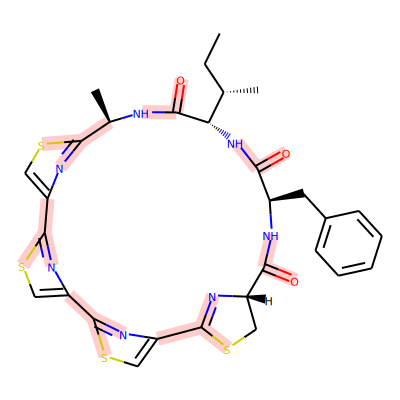

DEBUG:
0: NoChiralCenters
2: NoChiralCenters
3: NoChiralCenters
---


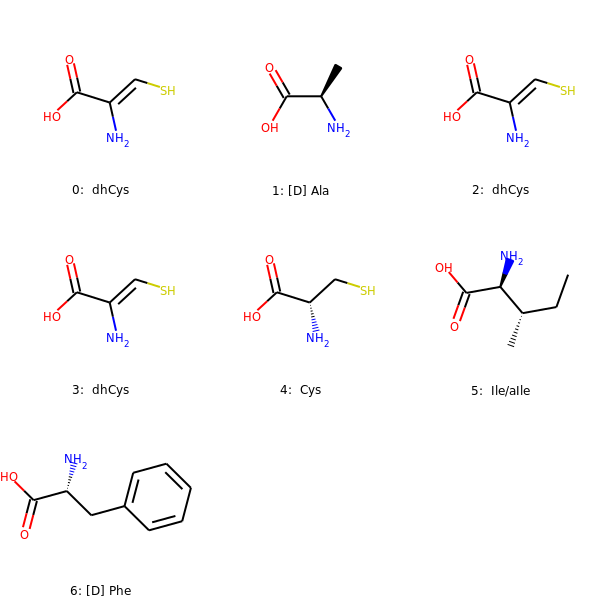

[(0, 'dhCys', ['NC(=CS)C(=O)O'], False),
 (1, 'Ala', ['C[C@@H](N)C(=O)O'], True),
 (2, 'dhCys', ['NC(=CS)C(=O)O'], False),
 (3, 'dhCys', ['NC(=CS)C(=O)O'], False),
 (4, 'Cys', ['N[C@@H](CS)C(=O)O'], False),
 (5, 'Ile/aIle', ['CC[C@H](C)[C@H](N)C(=O)O'], False),
 (6, 'Phe', ['N[C@H](Cc1ccccc1)C(=O)O'], True)]

In [17]:
compound_idx = 35
rban_record = mibig_results_json[compound_idx]
print(rban_record['id'], end='\n\n')
print(rban_record['isomericSmiles'], end='\n\n')

# display(get_colored_mol(rban_record))
display(SVG(get_colored_mol(rban_record, svg=True, resolution=(400,400))))

res = test_for_compound(rban_record)

display(
    rdc.Draw.MolsToGridImage(
        [rdc.MolFromSmiles(x[2][0]) for x in res],
        legends=[f'{x[0]}: {"[D]" if x[3] else ""} {x[1]}' for x in res]))
res

### Test all TestMIBig

In [18]:
for i, rban_record in enumerate(mibig_results_json):
    test_for_compound(rban_record, debug=False)

13: WTF: O=C(O)[C@@]1(O)CCCN1
